### Get label for training
* based on - toyData_v1.ipynb = initial work on [toy data](https://www.uniprot.org/uniprot/?query=goa%3A%28evidence%3Amanual%29+AND+%28+annotation%3A%28type%3Atransmem%29+OR+annotation%3A%28type%3Asignal%29+OR+annotation%3A%28type%3Apropep%29%29&sort=score)

* This dataset uses: all uniprot sequences with manual go annotation or swissprot (+go annotation) ~ 1.3 million sequences. Download tab delimited file with GO annotations. 
    * download [uniref90](https://www.uniprot.org/uniref/?query=uniprot:(goa%3A%28evidence%3Amanual%29+OR+%28reviewed%3Ayes+goa%3A%28*%29%29)+identity:0.9) tab-delimited version of these filwa, with reference sequence. filter by uniref. 
* filter by uniref90 (isin refSeq).
* parse/extract GO labels
    * some label filtering (min occurrence, remove most correlated)
* create train/test split using skmultilearn and save/export
    * OPT: could do 50% similarity filtering of test set, using [cd-hit-2d](http://weizhong-lab.ucsd.edu/cdhit-web-server/cgi-bin/index.cgi?cmd=cd-hit-2d)  or [expasy decrease_redundancy] (https://web.expasy.org/decrease_redundancy/)
    ( Can do 50 reduanndcy by 


In [1]:
import pandas as pd
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
LABELS_COLUMN = "Gene ontology (GO)"   # "Keywords" , 'Gene ontology (molecular function)' , HPU, Disorder

MIN_CLASS_COUNT = 4500

In [3]:
# df_raw = pd.read_csv("../Datasets/toy/toy1_loc.tsv.gz",sep="\t").drop_duplicates(subset="Sequence") # drop 100% duplicates  (orig size = 262135)

df_raw = pd.read_csv("unfiltered_goa_swprot.tab.gz", sep="\t").drop_duplicates(subset="Sequence")#.set_index("Sequence")
print(df_raw.shape)
display(df_raw.columns)

(1257711, 16)


Index(['Entry', 'Entry name', 'Status', 'Protein names', 'Gene names',
       'Organism', 'Length', 'Features', 'Keyword ID', 'Keywords',
       'Gene ontology (biological process)',
       'Gene ontology (cellular component)', 'Gene ontology (GO)',
       'Gene ontology (molecular function)', 'Gene ontology IDs', 'Sequence'],
      dtype='object')

* load uniref90/50 file and filter by it
* this is  ineffecient memory wise (using the whole sequence instead of ID).
    * could also try using "isin" instead of index join - but that won't affect the mmemory inefficiency

In [4]:
df_filt = pd.read_csv("uniref90_goa_swprot.tab.gz",sep="\t",usecols=["Reference sequence"])#.set_index("Reference sequence")
print(df_filt.shape)
df_filt.head()

(976070, 1)


,Reference sequence
0,MATKAKKNPRLASGRKRARQNVKLNAANTSLRSKYRTVVKNVEKAV...
1,MPPKPSAKGAKKSAKVQKSSRSGEKKKRSHRKESYSVYIYRVLKQV...
2,MATATMRPVDPARRWKSLYKVLNKPGPSSDEDWVPGPETIDALESS...
3,MVKTATFWRCLFFTLCGSFLTVTQAKAATSNASSFLEVSLRYFDEQ...
4,MQGVSATSNASSFLEVSLRYFDEQLLLDILPRAQCPGEDEGSPMDE...


In [5]:
%%time
# df_raw = df_raw.join(df_filt,how="inner")
df_raw = df_raw.loc[df_raw["Sequence"].isin(df_filt["Reference sequence"])]
print(df_raw.shape)

(898585, 16)
Wall time: 2.09 s


In [6]:
df_raw.rename(columns={"Reference sequence":"Sequence"},inplace=True)
df_raw.head()

,Entry,Entry name,Status,Protein names,Gene names,Organism,Length,Features,Keyword ID,Keywords,Gene ontology (biological process),Gene ontology (cellular component),Gene ontology (GO),Gene ontology (molecular function),Gene ontology IDs,Sequence
0,E9PXF8,MTMRD_MOUSE,reviewed,Myotubularin-related protein 13 (Inactive phos...,Sbf2,Mus musculus (Mouse),1872,Alternative sequence (1); Chain (1); Domain (6...,KW-0025; KW-0072; KW-0344; KW-0472; KW-0597; K...,Alternative splicing;Autophagy;Cell projection...,autophagy [GO:0006914]; regulation of GTPase a...,axon [GO:0030424]; endosome membrane [GO:00100...,axon [GO:0030424]; endosome membrane [GO:00100...,phosphatase binding [GO:0019902]; phosphatase ...,GO:0005774; GO:0006914; GO:0010008; GO:0016020...,MARLADYFIVVGYDHEKPAGPGEGLGKIIQRFPQQDWDDTPFPQGI...
1,Q10728,MYPT1_RAT,reviewed,Protein phosphatase 1 regulatory subunit 12A (...,Ppp1r12a Mbs Mypt1,Rattus norvegicus (Rat),1032,Alternative sequence (2); Chain (1); Modified ...,KW-0025; KW-0040; KW-0206; KW-0379; KW-0597; K...,ANK repeat;Alternative splicing;Cytoplasm;Cyto...,cellular response to drug [GO:0035690]; centro...,A band [GO:0031672]; centrosome [GO:0005813]; ...,A band [GO:0031672]; centrosome [GO:0005813]; ...,14-3-3 protein binding [GO:0071889]; enzyme in...,GO:0000278; GO:0000776; GO:0004721; GO:0004857...,MKMADAKQKRNEQLKRWIGSETDLEPPVVKRQKTKVKFDDGAVFLA...
2,P16646,PMP22_MOUSE,reviewed,Peripheral myelin protein 22 (PMP-22) (Growth ...,Pmp22 Gas-3 Gas3 Pmp-22,Mus musculus (Mouse),161,Chain (1); Glycosylation (1); Natural variant ...,KW-0131; KW-0225; KW-0325; KW-0338; KW-0472; K...,Cell cycle;Cell membrane;Disease mutation;Glyc...,actin cytoskeleton organization [GO:0030036]; ...,bicellular tight junction [GO:0005923]; cell s...,bicellular tight junction [GO:0005923]; cell s...,motor activity [GO:0003774],GO:0003774; GO:0005886; GO:0005923; GO:0006914...,MLLLLLGILFLHIAVLVLLFVSTIVSQWLVGNGHTTDLWQNCTTSA...
4,Q9Y263,PLAP_HUMAN,reviewed,Phospholipase A-2-activating protein (PLA2P) (...,PLAA PLAP,Homo sapiens (Human),795,Beta strand (5); Chain (1); Domain (2); Errone...,KW-0002; KW-0007; KW-0217; KW-0225; KW-0524; K...,3D-structure;Acetylation;Cell junction;Cytopla...,cellular response to lipopolysaccharide [GO:00...,cell [GO:0005623]; cell junction [GO:0030054];...,cell [GO:0005623]; cell junction [GO:0030054];...,phospholipase A2 activator activity [GO:001600...,GO:0005623; GO:0005634; GO:0005737; GO:0006644...,MTSGATRYRLSCSLRGHELDVRGLVCCAYPPGAFVSVSRDRTTRLW...
6,Q54WR4,PLDB_DICDI,reviewed,Phospholipase D B (EC 3.1.4.4) (Phosphatase D1...,pldB pld1 DDB_G0279483,Dictyostelium discoideum (Slime mold),1216,Active site (6); Calcium binding (1); Chain (1...,KW-0106; KW-0378; KW-0442; KW-0443; KW-0479; K...,Calcium;Cytoplasm;Cytoplasmic vesicle;Hydrolas...,cell motility [GO:0048870]; chemotaxis to cAMP...,cell cortex [GO:0005938]; cytoplasmic vesicle ...,cell cortex [GO:0005938]; cytoplasmic vesicle ...,calcium ion binding [GO:0005509]; N-acylphosph...,GO:0004630; GO:0005509; GO:0005773; GO:0005938...,MNLSQEHAINQNLHKNQKNEEKIEKKTINKDGRGQMNYDGEEGQGE...


In [7]:
display(df_raw.columns)

Index(['Entry', 'Entry name', 'Status', 'Protein names', 'Gene names',
       'Organism', 'Length', 'Features', 'Keyword ID', 'Keywords',
       'Gene ontology (biological process)',
       'Gene ontology (cellular component)', 'Gene ontology (GO)',
       'Gene ontology (molecular function)', 'Gene ontology IDs', 'Sequence'],
      dtype='object')

### add uniref50 clusters - for filtering the test set vs train later!

* problem - lack of cluster Ids for non reference sequences..   - otherwise we could simply drop duplicates between (sorted) train/test according to the cluster id. 

In [8]:
df_50 = pd.read_csv("uniref50_goa_swprot.tab.gz",sep="\t",usecols=["Reference sequence","Cluster ID"]).set_index("Reference sequence")
print(df_raw.shape)
df_raw = df_raw.merge(df_50,left_on="Sequence",right_index=True,how="left")
print(df_raw.shape)

display(df_raw.tail())

(898585, 16)
(898585, 17)


,Entry,Entry name,Status,Protein names,Gene names,Organism,Length,Features,Keyword ID,Keywords,Gene ontology (biological process),Gene ontology (cellular component),Gene ontology (GO),Gene ontology (molecular function),Gene ontology IDs,Sequence,Cluster ID
1354934,V5IQA9,V5IQA9_NEUCR,unreviewed,Acyl-CoA dehydrogenase (Acyl-CoA dehydrogenase...,NCU09885,Neurospora crassa (strain ATCC 24698 / 74-OR23...,438,Domain (3),KW-0274; KW-0285; KW-0560; KW-1185,FAD;Flavoprotein;Oxidoreductase;Reference prot...,NaN,plasma membrane [GO:0005886],plasma membrane [GO:0005886]; acyl-CoA dehydro...,acyl-CoA dehydrogenase activity [GO:0003995]; ...,GO:0003995; GO:0005886; GO:0050660; GO:0052890,MPTFIKSAARSARWLPRITPRSTASGHNAFSTSAHRQLMAMAGFTE...,NaN
1354935,V5IQ47,V5IQ47_NEUCR,unreviewed,KH domain-containing protein (KH domain-contai...,NCU01665,Neurospora crassa (strain ATCC 24698 / 74-OR23...,523,Compositional bias (4); Domain (2); Region (3),KW-1185,Reference proteome,NaN,nucleus [GO:0005634],nucleus [GO:0005634]; RNA binding [GO:0003723],RNA binding [GO:0003723],GO:0003723; GO:0005634,MDDAERRSAKRSRFDQTEPEPKRVSRFDRRSRSPPARKSDSGRDRD...,NaN
1354936,U9W500,U9W500_NEUCR,unreviewed,"Glycosyl transferase (Glycosyl transferase, va...",NCU00244,Neurospora crassa (strain ATCC 24698 / 74-OR23...,311,NaN,KW-0808; KW-1185,Reference proteome;Transferase,glycogen biosynthetic process [GO:0005978],NaN,glycogenin glucosyltransferase activity [GO:00...,glycogenin glucosyltransferase activity [GO:00...,GO:0005978; GO:0008466,MAVDYPTNMIWSTLVTKRAYLGGALVLNHSLKKVGSRYQLKIMVTR...,NaN
1354937,V5IPC4,V5IPC4_NEUCR,unreviewed,Rhomboid family protein (Rhomboid family prote...,NCU06839,Neurospora crassa (strain ATCC 24698 / 74-OR23...,373,Compositional bias (1); Region (1); Transmembr...,KW-0472; KW-0812; KW-1133; KW-1185,Membrane;Reference proteome;Transmembrane;Tran...,"retrograde vesicle-mediated transport, Golgi t...",Golgi apparatus [GO:0005794]; integral compone...,Golgi apparatus [GO:0005794]; integral compone...,NaN,GO:0005794; GO:0006890; GO:0016021,MPPRINLPPVTRISLLALGLQSVLSAAIRYRQWTAHSEIVIPYLNL...,NaN
1354938,V5IRP0,V5IRP0_NEUCR,unreviewed,Methylenetetrahydrofolate dehydrogenase (Methy...,NCU00963,Neurospora crassa (strain ATCC 24698 / 74-OR23...,342,Compositional bias (1); Domain (2); Region (1),KW-1185,Reference proteome,purine nucleobase biosynthetic process [GO:000...,cytosol [GO:0005829],cytosol [GO:0005829]; methylenetetrahydrofolat...,methylenetetrahydrofolate dehydrogenase (NAD+)...,GO:0004487; GO:0004488; GO:0005829; GO:0009113,MEAQQVPKTCKVILSDTIAKKLLSEVRETLAKIEGPNASKPTLAAF...,UniRef50_V5IRP0


## Extract Labels/targets
* currently looks at all GO annotations - can use only molecular/biological, etc'  
* __Important__ - amount of minimal examples required to keep a label + correlation filtering! 
* split/expand target labels column , without regard to order;
    * https://datascience.stackexchange.com/questions/11797/split-a-list-of-values-into-columns-of-a-dataframe
    
    
    * expanding this with multilabel binarizer FAILS due to memory when we have a lot of items - so we may need to filter this in advance.. 
        * e.g. https://stackoverflow.com/questions/48707117/count-of-elements-in-lists-within-pandas-data-frame

In [9]:
## copy the df, keeping only the sequence (and Entry ID?) and the labels column
df = df_raw[["Cluster ID","Entry","Sequence",LABELS_COLUMN]]

In [10]:
## https://stackoverflow.com/questions/48707117/count-of-elements-in-lists-within-pandas-data-frame

a = pd.Series([item for sublist in df[LABELS_COLUMN].str.split(";") for item in sublist])
a.value_counts()

cytoplasm [GO:0005737]                                                    145926
 ATP binding [GO:0005524]                                                 101405
integral component of membrane [GO:0016021]                                92447
 plasma membrane [GO:0005886]                                              75866
 nucleus [GO:0005634]                                                      70049
                                                                           ...  
 positive regulation of gluconate transmembrane transport [GO:0035432]         1
 purine nucleotide-sugar transmembrane transport [GO:0090480]                  1
cholate 12-alpha dehydrogenase activity [GO:0047013]                           1
2-hydroxyhexa-2,4-dienoate hydratase activity [GO:0034856]                     1
 presynaptic active zone dense projection [GO:0097445]                         1
Length: 33475, dtype: int64

In [11]:
### get only index/items above a minimal frequency
frequent_labels = a.value_counts()[a.value_counts()>MIN_CLASS_COUNT].index.astype(set)
print(len(frequent_labels))
frequent_labels

124


Index(['cytoplasm [GO:0005737]', ' ATP binding [GO:0005524]',
       'integral component of membrane [GO:0016021]',
       ' plasma membrane [GO:0005886]', ' nucleus [GO:0005634]',
       ' integral component of membrane [GO:0016021]', 'nucleus [GO:0005634]',
       ' metal ion binding [GO:0046872]', 'cytosol [GO:0005829]',
       ' structural constituent of ribosome [GO:0003735]',
       ...
       ' olfactory receptor activity [GO:0004984]',
       ' NAD binding [GO:0051287]',
       ' translation initiation factor activity [GO:0003743]',
       ' mRNA splicing, via spliceosome [GO:0000398]', ' synapse [GO:0045202]',
       ' metalloendopeptidase activity [GO:0004222]',
       ' DNA recombination [GO:0006310]',
       'cytosolic large ribosomal subunit [GO:0022625]',
       ' endoplasmic reticulum to Golgi vesicle-mediated transport [GO:0006888]',
       ' trans-Golgi network [GO:0005802]'],
      dtype='object', length=124)

In [12]:
df["targets"] = df[LABELS_COLUMN].str.split(";").apply(set) ### if using uniprot keywordsa s target
df["targets"].tail()

C:\Users\Dan Ofer\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


1354934    { oxidoreductase activity, acting on the CH-CH...
1354935    { RNA binding [GO:0003723], nucleus [GO:0005634]}
1354936    { glycogen biosynthetic process [GO:0005978], ...
1354937    {Golgi apparatus [GO:0005794],  integral compo...
1354938    {cytosol [GO:0005829],  methylenetetrahydrofol...
Name: targets, dtype: object

In [13]:
## filter by the frequent labels
print("before: \n",df["targets"].tail().values)
df["targets"] = df["targets"].apply(lambda x: x.intersection(frequent_labels))
print("\n after",df["targets"].tail().values)

before: 
 [{' oxidoreductase activity, acting on the CH-CH group of donors, with a flavin as acceptor [GO:0052890]', 'plasma membrane [GO:0005886]', ' acyl-CoA dehydrogenase activity [GO:0003995]', ' flavin adenine dinucleotide binding [GO:0050660]'}
 {' RNA binding [GO:0003723]', 'nucleus [GO:0005634]'}
 {' glycogen biosynthetic process [GO:0005978]', 'glycogenin glucosyltransferase activity [GO:0008466]'}
 {'Golgi apparatus [GO:0005794]', ' integral component of membrane [GO:0016021]', ' retrograde vesicle-mediated transport, Golgi to endoplasmic reticulum [GO:0006890]'}
 {'cytosol [GO:0005829]', ' methylenetetrahydrofolate dehydrogenase (NADP+) activity [GO:0004488]', ' purine nucleobase biosynthetic process [GO:0009113]', ' methylenetetrahydrofolate dehydrogenase (NAD+) activity [GO:0004487]'}]

 after [{'plasma membrane [GO:0005886]'}
 {' RNA binding [GO:0003723]', 'nucleus [GO:0005634]'} set()
 {'Golgi apparatus [GO:0005794]', ' integral component of membrane [GO:0016021]'}
 {'cy

C:\Users\Dan Ofer\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


* https://gist.github.com/danieljfarrell/90aefee59c5292740f0b
    * example of using sklearn mlb

In [14]:
df["targets"].tail()

1354934                       {plasma membrane [GO:0005886]}
1354935    { RNA binding [GO:0003723], nucleus [GO:0005634]}
1354936                                                   {}
1354937    {Golgi apparatus [GO:0005794],  integral compo...
1354938                               {cytosol [GO:0005829]}
Name: targets, dtype: object

In [15]:
mlb = MultiLabelBinarizer(sparse_output =False)
feature_column_name = 'targets'
feature_matrix = mlb.fit_transform(df[feature_column_name])
feature_names = mlb.classes_

# Create feature-matrix data frame
feature_df = pd.DataFrame(data=feature_matrix, columns=feature_names, index=df.index)

feature_df

,"4 iron, 4 sulfur cluster binding [GO:0051539]",ATP binding [GO:0005524],ATPase activity [GO:0016887],ATPase-coupled transmembrane transporter activity [GO:0042626],DNA binding [GO:0003677],DNA recombination [GO:0006310],DNA repair [GO:0006281],DNA replication [GO:0006260],DNA-binding transcription factor activity [GO:0003700],"DNA-binding transcription factor activity, RNA polymerase II-specific [GO:0000981]",...,endoplasmic reticulum membrane [GO:0005789],extracellular region [GO:0005576],extracellular space [GO:0005615],integral component of membrane [GO:0016021],integral component of plasma membrane [GO:0005887],mitochondrion [GO:0005739],nucleolus [GO:0005730],nucleus [GO:0005634],plasma membrane [GO:0005886],ribosome [GO:0005840]
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1354934,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1354935,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1354936,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1354937,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### filter rare classes

In [16]:
feature_df.sum(axis=0)

 4 iron, 4 sulfur cluster binding [GO:0051539]                       6910
 ATP binding [GO:0005524]                                          101405
 ATPase activity [GO:0016887]                                       16178
 ATPase-coupled transmembrane transporter activity [GO:0042626]      5465
 DNA binding [GO:0003677]                                           28592
                                                                    ...  
mitochondrion [GO:0005739]                                          13801
nucleolus [GO:0005730]                                               7209
nucleus [GO:0005634]                                                58189
plasma membrane [GO:0005886]                                        17120
ribosome [GO:0005840]                                               15167
Length: 124, dtype: int64

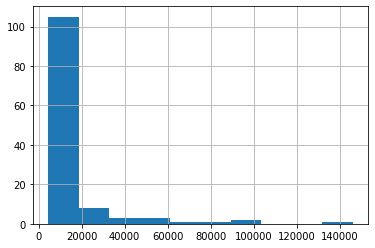

In [17]:
feature_df.sum(axis=0).hist()

In [18]:
feature_df = feature_df.loc[:, ((feature_df.sum() >= MIN_CLASS_COUNT) & (feature_df.sum() < int(feature_df.shape[0]/0.96)))]
feature_df.head(3)

,"4 iron, 4 sulfur cluster binding [GO:0051539]",ATP binding [GO:0005524],ATPase activity [GO:0016887],ATPase-coupled transmembrane transporter activity [GO:0042626],DNA binding [GO:0003677],DNA recombination [GO:0006310],DNA repair [GO:0006281],DNA replication [GO:0006260],DNA-binding transcription factor activity [GO:0003700],"DNA-binding transcription factor activity, RNA polymerase II-specific [GO:0000981]",...,endoplasmic reticulum membrane [GO:0005789],extracellular region [GO:0005576],extracellular space [GO:0005615],integral component of membrane [GO:0016021],integral component of plasma membrane [GO:0005887],mitochondrion [GO:0005739],nucleolus [GO:0005730],nucleus [GO:0005634],plasma membrane [GO:0005886],ribosome [GO:0005840]
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
feature_df.sum(axis=0)

 4 iron, 4 sulfur cluster binding [GO:0051539]                       6910
 ATP binding [GO:0005524]                                          101405
 ATPase activity [GO:0016887]                                       16178
 ATPase-coupled transmembrane transporter activity [GO:0042626]      5465
 DNA binding [GO:0003677]                                           28592
                                                                    ...  
mitochondrion [GO:0005739]                                          13801
nucleolus [GO:0005730]                                               7209
nucleus [GO:0005634]                                                58189
plasma membrane [GO:0005886]                                        17120
ribosome [GO:0005840]                                               15167
Length: 124, dtype: int64

In [20]:
df.shape

(898585, 5)

In [21]:
feature_df.shape

(898585, 124)

In [22]:
df.head()

,Cluster ID,Entry,Sequence,Gene ontology (GO),targets
0,NaN,E9PXF8,MARLADYFIVVGYDHEKPAGPGEGLGKIIQRFPQQDWDDTPFPQGI...,axon [GO:0030424]; endosome membrane [GO:00100...,{ membrane [GO:0016020]}
1,NaN,Q10728,MKMADAKQKRNEQLKRWIGSETDLEPPVVKRQKTKVKFDDGAVFLA...,A band [GO:0031672]; centrosome [GO:0005813]; ...,{ positive regulation of transcription by RNA ...
2,UniRef50_P16646,P16646,MLLLLLGILFLHIAVLVLLFVSTIVSQWLVGNGHTTDLWQNCTTSA...,bicellular tight junction [GO:0005923]; cell s...,{ proteasome-mediated ubiquitin-dependent prot...
4,UniRef50_Q9Y263,Q9Y263,MTSGATRYRLSCSLRGHELDVRGLVCCAYPPGAFVSVSRDRTTRLW...,cell [GO:0005623]; cell junction [GO:0030054];...,{ proteasome-mediated ubiquitin-dependent prot...
6,UniRef50_Q54WR4,Q54WR4,MNLSQEHAINQNLHKNQKNEEKIEKKTINKDGRGQMNYDGEEGQGE...,cell cortex [GO:0005938]; cytoplasmic vesicle ...,"{ calcium ion binding [GO:0005509], membrane ..."


In [23]:
df = pd.concat([df,feature_df],axis=1).drop(["targets","Gene ontology (GO)"],axis=1)
print(df.shape)
df

(898585, 127)


,Cluster ID,Entry,Sequence,"4 iron, 4 sulfur cluster binding [GO:0051539]",ATP binding [GO:0005524],ATPase activity [GO:0016887],ATPase-coupled transmembrane transporter activity [GO:0042626],DNA binding [GO:0003677],DNA recombination [GO:0006310],DNA repair [GO:0006281],...,endoplasmic reticulum membrane [GO:0005789],extracellular region [GO:0005576],extracellular space [GO:0005615],integral component of membrane [GO:0016021],integral component of plasma membrane [GO:0005887],mitochondrion [GO:0005739],nucleolus [GO:0005730],nucleus [GO:0005634],plasma membrane [GO:0005886],ribosome [GO:0005840]
0,NaN,E9PXF8,MARLADYFIVVGYDHEKPAGPGEGLGKIIQRFPQQDWDDTPFPQGI...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NaN,Q10728,MKMADAKQKRNEQLKRWIGSETDLEPPVVKRQKTKVKFDDGAVFLA...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,UniRef50_P16646,P16646,MLLLLLGILFLHIAVLVLLFVSTIVSQWLVGNGHTTDLWQNCTTSA...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,UniRef50_Q9Y263,Q9Y263,MTSGATRYRLSCSLRGHELDVRGLVCCAYPPGAFVSVSRDRTTRLW...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,UniRef50_Q54WR4,Q54WR4,MNLSQEHAINQNLHKNQKNEEKIEKKTINKDGRGQMNYDGEEGQGE...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1354934,NaN,V5IQA9,MPTFIKSAARSARWLPRITPRSTASGHNAFSTSAHRQLMAMAGFTE...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1354935,NaN,V5IQ47,MDDAERRSAKRSRFDQTEPEPKRVSRFDRRSRSPPARKSDSGRDRD...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1354936,NaN,U9W500,MAVDYPTNMIWSTLVTKRAYLGGALVLNHSLKKVGSRYQLKIMVTR...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1354937,NaN,V5IPC4,MPPRINLPPVTRISLLALGLQSVLSAAIRYRQWTAHSEIVIPYLNL...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## train/test stratified split
### then filter test by 50% identity with training data

* uses scikit multileanr package  - http://scikit.ml/stratification.html
    * !pip install scikit-multilearn

In [24]:
df.head().iloc[:,3:]

,"4 iron, 4 sulfur cluster binding [GO:0051539]",ATP binding [GO:0005524],ATPase activity [GO:0016887],ATPase-coupled transmembrane transporter activity [GO:0042626],DNA binding [GO:0003677],DNA recombination [GO:0006310],DNA repair [GO:0006281],DNA replication [GO:0006260],DNA-binding transcription factor activity [GO:0003700],"DNA-binding transcription factor activity, RNA polymerase II-specific [GO:0000981]",...,endoplasmic reticulum membrane [GO:0005789],extracellular region [GO:0005576],extracellular space [GO:0005615],integral component of membrane [GO:0016021],integral component of plasma membrane [GO:0005887],mitochondrion [GO:0005739],nucleolus [GO:0005730],nucleus [GO:0005634],plasma membrane [GO:0005886],ribosome [GO:0005840]
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
df.iloc[:,95:]

,synapse [GO:0045202],tRNA binding [GO:0000049],trans-Golgi network [GO:0005802],transcription factor binding [GO:0008134],transcription regulatory region DNA binding [GO:0044212],translation [GO:0006412],translation initiation factor activity [GO:0003743],transmembrane transport [GO:0055085],transmembrane transporter activity [GO:0022857],ubiquitin protein ligase activity [GO:0061630],...,endoplasmic reticulum membrane [GO:0005789],extracellular region [GO:0005576],extracellular space [GO:0005615],integral component of membrane [GO:0016021],integral component of plasma membrane [GO:0005887],mitochondrion [GO:0005739],nucleolus [GO:0005730],nucleus [GO:0005634],plasma membrane [GO:0005886],ribosome [GO:0005840]
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1354934,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1354935,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1354936,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1354937,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
##### warning! slow for many labels
# ### stratified sampling of dataset into set train/test splits for comparison
# # !pip install scikit-multilearn

# print(LABELED_DATA_FILE_PATH)
# df = pd.read_csv(LABELED_DATA_FILE_PATH)#.sample(n=2134)#.iloc[:,0:5]
column_names = df.columns


# ## stratified multilabel sampling - http://scikit.ml/stratification.html
# from skmultilearn.model_selection import iterative_train_test_split
X_train,y_train, X_test, y_test = iterative_train_test_split(X=df.values, y=df.iloc[:,93:].values, test_size = 0.25)

print(X_train.shape)
print(X_test.shape)

# X_train,y_train, X_test, y_test = iterative_train_test_split(X=df.values, y=df.drop(["Sequence"],axis=1).values, test_size = 0.25)
# 
df_train = pd.DataFrame(X_train,columns=column_names)
df_test = pd.DataFrame(X_test,columns=column_names)

# display(df_train.head())

# df_train.to_csv("labelled_toy_seqs_v1_TRAIN.csv",index=False)
# df_test.to_csv("labelled_toy_seqs_v1_TEST.csv",index=False)

In [30]:
print(X_train.shape)
print(X_test.shape)

(673938, 127)
(224647, 127)


In [31]:
df_train = pd.DataFrame(X_train,columns=column_names)
df_test = pd.DataFrame(X_test,columns=column_names)

* filter sequences in df_test that have >50% similarity to sequences in df_train , i.e same uniref50 clusters (or both missing cluster)

In [34]:
df_test = df_test.loc[~df_test["Cluster ID"].isin(df_train["Cluster ID"])]
print(df_test.shape[0])
df_test.tail()

100808


,Cluster ID,Entry,Sequence,"4 iron, 4 sulfur cluster binding [GO:0051539]",ATP binding [GO:0005524],ATPase activity [GO:0016887],ATPase-coupled transmembrane transporter activity [GO:0042626],DNA binding [GO:0003677],DNA recombination [GO:0006310],DNA repair [GO:0006281],...,endoplasmic reticulum membrane [GO:0005789],extracellular region [GO:0005576],extracellular space [GO:0005615],integral component of membrane [GO:0016021],integral component of plasma membrane [GO:0005887],mitochondrion [GO:0005739],nucleolus [GO:0005730],nucleus [GO:0005634],plasma membrane [GO:0005886],ribosome [GO:0005840]
224633,UniRef50_Q8TRJ9,Q8TRJ9,MMIVRHLKELYGYRNLIWQLAWSEFKLRYKNSILGYFWSLLEPMLM...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
224634,UniRef50_Q8TU97,Q8TU97,MNDVDLLRVKIMNEETTIKWIEDIDTVDKMISFTYSSVQKNFEEEL...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
224636,UniRef50_Q8TJ48,Q8TJ48,MSDEENVQLFKALSEETRYKIIKVLLKGERCACEIPDLIGKTQSNT...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
224639,UniRef50_Q8TR10,Q8TR10,MQMKLAALISGGKDSVFAIHKALEEGHEVTHLINIIPARDDSYMYH...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
224645,UniRef50_Q8TJ55,Q8TJ55,MTEYTKLHNIFKRIGWEEVEGFSELNKIFIIASLAQDTPLMFLDEP...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
df_train.iloc[:,3:].sum(axis=0).describe()

count       124.000000
mean      11203.298387
std       15287.138597
min        3379.000000
25%        4299.750000
50%        5685.000000
75%       10816.500000
max      109444.000000
dtype: float64

In [35]:
## check that we haven't lost labels after this filtering
df_test.iloc[:,3:].sum(axis=0).describe()

count      124.000000
mean      1620.225806
std       2140.384453
min        221.000000
25%        661.750000
50%        888.000000
75%       1633.250000
max      15531.000000
dtype: float64

### Save out 


In [ ]:
# df_raw["Sequence"].to_csv("toyseqs.csv",index=False)

In [37]:
df_train.drop(["Cluster ID","Entry"],axis=1).to_csv("SWP_train_go-all_v1.csv.gz",index=False,compression="gzip",encoding="utf-8")
df_test.drop(["Cluster ID","Entry"],axis=1).to_csv("SWP_test_go-all_v1.csv.gz",index=False,compression="gzip",encoding="utf-8")